## 第7章 ロジスティクスネットワークの最適設計を行う10本ノック

この記事は[「Python実践データ分析100本ノック」](https://www.amazon.co.jp/dp/B07ZSGSN9S/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)の演習を実際にやってみたという内容になっています。今まで自己流でやってきましたが、一度他の方々がどのような考え方やコーディングをしているのか勉強してみようと思ってやってみました。本書は実際の業務に活用する上でとても参考になる内容だと思っています。データ分析に関わる仕事をしたい方にお勧めしたいです。

輸送問題の最適化という事で、pulpとortoolpyを利用します。
私も今回初めて利用するので勉強させていただきます。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/blob/master/ml/data100/07/07_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/blob/master/ml/data100/07/07_nb.ipynb)

### 筆者の環境

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6020


In [2]:
!python -V

Python 3.7.3


基本的なライブラリをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('pandas version :', pd.__version__)

matplotlib version : 3.0.3
scipy version : 1.4.1
numpy version : 1.16.2
pandas version : 1.0.3


## 解答

### ノック 61 : 輸送最適化問題を解いてみよう

実際にpulpとortoolpyを読み込んで最適化問題を解きます。

In [4]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

In [5]:
# データ読み込み
df_tc = pd.read_csv('trans_cost.csv', index_col="工場")
df_tc

,F1,F2,F3,F4
工場,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


In [6]:
df_demand = pd.read_csv('demand.csv')
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [7]:
df_supply = pd.read_csv('supply.csv')
df_supply

,W1,W2,W3
0,35,41,42


In [8]:
# 初期設定 #
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)

# productは直積を作る関数
# 二つの変数が取るすべての組み合わせを作る
pr = list(product(range(nw), range(nf)))

print(nw)
print(nf)
print(pr)

3
4
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [9]:
# 数理モデル作成 #
m1 = model_min()
v1 = {(i,j):LpVariable('v%d_%d'%(i,j),lowBound=0) for i,j in pr}

# (x,x)というタプル型でアクセス出来るようにする
print(v1)

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}


In [10]:
m1 += lpSum(df_tc.iloc[i][j]*v1[i,j] for i,j in pr)

# コストの足し上げ
for i in range(nw):
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]

for j in range(nf):
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]

# 最適化計算
m1.solve()

1

In [11]:
# 総輸送コストの計算
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
  i,j = k[0],k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j]*value(x)
  
print(df_tr_sol)
print("全輸送コスト : ", total_cost)

    F1  F2  F3  F4
工場                
W1  28   7   0   0
W2   0   0  31   5
W3   0  22   0  20
全輸送コスト :  1296.0


### ノック 62 : 最適輸送ルートをネットワークで確認しよう

In [12]:
# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv('trans_route_pos.csv')

df_pos

,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


/Users/hiroshi/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


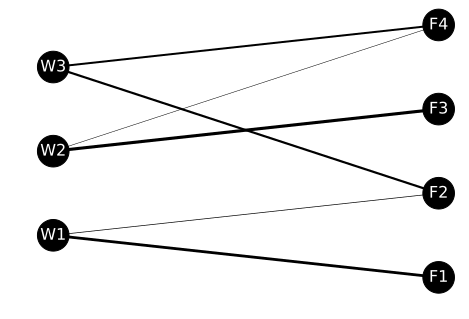

In [13]:
import networkx as nx

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i==j):
      # 辺の追加
      G.add_edge(df_pos.columns[i],df_pos.columns[j])
      # エッジの重みの追加
      if num_pre<len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
        elif(df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edge_weights.append(weight)
        

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0],df_pos[node][1])
  
nx.draw(G, pos, with_labels=True,font_size=16, node_size = 1000, node_color='k', font_color='w', width=edge_weights)
plt.show()

実際に可視化してみると、とてもわかりやすいです。

### ノック 63 : 最適輸送ルートが制約条件内に収まっているか確認してみよう

In [14]:
# データの読み込み
df_demand = pd.read_csv('demand.csv')
df_demand

,F1,F2,F3,F4
0,28,29,31,25


In [15]:
# データの読み込み
df_supply = pd.read_csv('supply.csv')
df_supply

,W1,W2,W3
0,35,41,42


In [16]:
# 制約条件計算関数
# 需要側
def condition_demand(df_tr,df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if (temp_sum >= df_demand.iloc[0][i]):
      flag[i] = 1
  return flag
      
# 供給側
def condition_supply(df_tr, df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

print("需要条件計算結果:"+str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果:"+str(condition_supply(df_tr_sol,df_supply)))

需要条件計算結果:[1. 1. 1. 1.]
供給条件計算結果:[1. 1. 1.]


すべての制約条件が1となり、条件を満たしている事がわかります。

### ノック 64 : 生産計画に関するデータを読み込んでみよう

生産計画に関するデータをいつも通り読み込みます。

- product_plan_material.csv : 製品の製造に必要な原料の割合
- product_plan_profit.csv : 製品の利益
- product_plan_stock.csv : 原料の在庫
- product_plan.csv : 製品の生産量

In [17]:
df_material = pd.read_csv('product_plan_material.csv', index_col="製品")
df_material

,原料1,原料2,原料3
製品,,,
製品1,1,4,3
製品2,2,4,1


In [18]:
df_profit = pd.read_csv('product_plan_profit.csv', index_col="製品")
df_profit

,利益
製品,
製品1,5.0
製品2,4.0


In [19]:
df_stock = pd.read_csv('product_plan_stock.csv', index_col="項目")
df_stock

,原料1,原料2,原料3
項目,,,
在庫,40,80,50


In [20]:
df_plan = pd.read_csv('product_plan.csv', index_col="製品")
df_plan

,生産量
製品,
製品1,16
製品2,0


### ノック 65 : 利益を計算する関数を作って見よう

 CSVから読み取ったデータから利益を計算させる関数です。

In [21]:
def product_plan(df_profit,df_plan):
  profit = 0
  for i in range(len(df_profit.index)):
    for j in range(len(df_plan.columns)):
      profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
  return profit

print("総利益:"+str(product_plan(df_profit,df_plan)))

総利益:80.0


### ノック 66 : 生産最適化問題を問いてみよう

目的関数とした利益の関数を最大化するように最適化を行います。

In [22]:
from ortoolpy import model_max

df = df_material.copy()
inv = df_stock

m = model_max()
v1 = {(i):LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_profit))}
m += lpSum(df_profit.iloc[i] * v1[i] for i in range(len(df_profit)))
for i in range(len(df_material.columns)):
  m += lpSum(df_material.iloc[j,i] * v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]
m.solve()

df_plan_sol = df_plan.copy()
for k,x in v1.items():
  df_plan_sol.iloc[k] = value(x)
  
print(df_plan_sol)
print("総利益 : ", value(m.objective))

      生産量
製品       
製品1  15.0
製品2   5.0
総利益 :  95.0


### ノック 67 : 最適生産計画が制約条件内に長待て散るどうかを確認しよう

In [23]:
# 制約条件計算関数
def condition_stock(df_plan,df_material,df_stock):
  flag = np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):  
    temp_sum = 0
    for j in range(len(df_material.index)):  
      temp_sum = temp_sum + df_material.iloc[j][i]*float(df_plan.iloc[j])
    if (temp_sum<=float(df_stock.iloc[0][i])):
      flag[i] = 1
    print(df_material.columns[i]+"  使用量:"+str(temp_sum)+", 在庫:"+str(float(df_stock.iloc[0][i])))
  return flag

print("制約条件計算結果:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1  使用量:25.0, 在庫:40.0
原料2  使用量:80.0, 在庫:80.0
原料3  使用量:50.0, 在庫:50.0
制約条件計算結果:[1. 1. 1.]


### ノック 68 : ロジスティックネットワーク設計問題を解いてみよう

輸送ルートの設計と生産計画の設計を一つの設計として考えます。目的関数を輸送コストと映像コストの和として設定します。

In [24]:
製品 = list('AB')
需要地 = list('PQ')
工場 = list('XY')
レーン = (2,2)

In [25]:
製品

['A', 'B']

In [26]:
需要地

['P', 'Q']

In [27]:
工場

['X', 'Y']

In [28]:
レーン

(2, 2)

In [29]:
# 輸送費表
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=['需要地','工場'])
tbdi['輸送費'] = [1,2,3,1]
print(tbdi)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1


In [30]:
# 需要表
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=['需要地','製品'])
tbde['需要'] = [10,10,20,20]
print(tbde)

  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20


In [31]:
# 生産表
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k,nl in zip (工場,レーン) for l in range(nl) for i in 製品), 
                    columns=['工場','レーン','製品','下限','上限'])
tbfa['生産費'] = [1,np.nan,np.nan,1,3,np.nan,5,3]
tbfa.dropna(inplace=True)
tbfa.loc[4,'上限']=10
print(tbfa)

  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0


In [32]:
from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde,tbdi,tbfa)
print(tbfa)
print(tbdi2)

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000009  20.0
3  X    1  B   0   inf  1.0  v000010  10.0
4  Y    0  A   0  10.0  3.0  v000011  10.0
6  Y    1  A   0   inf  5.0  v000012   0.0
7  Y    1  B   0   inf  3.0  v000013  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0


### ノック 69 : 最適ネットワークにおける輸送コストとその内訳を計算しよう

In [33]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト : ", trans_cost)

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0
総輸送コスト :  80.0


### ノック 70 : 最適ネットワークにおける生産コストとその内訳を計算しよう

In [34]:
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト:"+str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000001  10.0
1   P  X    1  B  v000002  10.0
2   Q  X    3  A  v000003  10.0
3   Q  X    3  B  v000004   0.0
4   P  Y    2  A  v000005   0.0
5   P  Y    2  B  v000006   0.0
6   Q  Y    1  A  v000007  10.0
7   Q  Y    1  B  v000008  20.0
総輸送コスト:80.0


## 関連記事
- [第1章 ウェブからの注文数を分析する10本ノック](/ml/data100/01/)
- [第2章 小売店のデータでデータ加工を行う10本ノック](/ml/data100/02/)
- [第3章 顧客の全体像を把握する10本ノック](/ml/data100/03/)
- [第4章 顧客の行動を予測する10本ノック](/ml/data100/04/)
- [第5章 顧客の退会を予測する10本ノック](/ml/data100/05/)
- [第6章 物流の最適ルートをコンサルティングする10本ノック](/ml/data100/06/)
- [第7章 ロジスティクスネットワークの最適設計を行う10本ノック](/ml/data100/07/)
- [第8章 数値シミュレーションで消費者行動を予測する10本ノック](/ml/data100/08/)
- [第9章 潜在顧客を把握するための画像認識10本ノック](/ml/data100/09/)
- [第10章 アンケート分析を行うための自然言語処理10本ノック](/ml/data100/10/)